In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import Binarizer

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score,roc_auc_score
from sklearn.metrics import precision_recall_curve,roc_curve,confusion_matrix

In [20]:
def model_basic(x_train, y_train, x_test, y_test): 
    models = [
        LogisticRegression(),
        LinearDiscriminantAnalysis(),
        GaussianNB(),
        RandomForestClassifier(),
        XGBClassifier()
    ]

    rdict={'model':[],'acc_train':[], 'auc_train':[], 'acc_test':[],'precision':[],'recall':[],'f1_score':[], 'AUC_test':[]}


    for clf in models:
        clf = clf.fit(x_train, y_train)
    #1열:Train
        y_hat = clf.predict(x_train)
        results_train  = (round(accuracy_score(y_train,y_hat),2),round(roc_auc_score(y_train,y_hat),2))
    #2열:Test
        y_hat = clf.predict(x_test)
        results = (round(accuracy_score(y_test,y_hat),2),
                        round(precision_score(y_test,y_hat),2),
                        round(recall_score(y_test,y_hat),2),
                        round(f1_score(y_test,y_hat),2),
                        round(roc_auc_score(y_test,y_hat),2))

        rdict['model'].append(clf); 
        rdict['acc_train'].append(results_train[0])
        rdict['auc_train'].append(results_train[1])
        
        rdict['acc_test'].append(results[0])
        rdict['precision'].append(results[1])
        rdict['recall'].append(results[2])
        rdict['f1_score'].append(results[3])
        rdict['AUC_test'].append(results[4])   

        confusion = confusion_matrix(y_test, y_hat)

        print(confusion)

    rdf_final = pd.DataFrame(data=rdict)
    return rdf_final

In [21]:
def eval(test,pred):
    acc = accuracy_score(test,pred)
    f1 = f1_score(test,pred)
    precision = precision_score(test,pred)
    recall = recall_score(test,pred)
    print('##############\n',confusion_matrix(test,pred),
    "############\n",f'acc_score: {acc}\n f1_score: {f1} \n precision: {precision} \n recall: {recall}')

## 임계값 =[] 리스트생성 후 for 구문
def get_eval_by_threshold(y_test , pred_proba_c1, thresholds=[0.5,0.52,0.54,0.56,0.58,0.6,0.62]):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        eval(y_test , custom_predict)


def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    

## roc curve_plot    
def roc_curve_plot(y_test,pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test,pred_proba) ## 입력시 1레이블 컬럼만 추출
    
    # Roc curve를 plot 곡선으로 기름
    plt.plot(fprs,tprs,label='ROC')
    ## 가운데 대각선 직선을 그림
    plt.plot([0,1],[0,1],"k--",label="ramdom")
    
    ## fpr x축을 scale을 0.1단위로 변경 x,y축 명 설정
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1-sensitivity)')
    plt.ylabel('TPR(recall)')
    plt.legend()
    plt.show()

In [22]:
train = pd.read_csv('./datasets/불균형처리/boder_코스닥_power_train.csv',index_col=0)
train_x = train.drop(['target_3'],axis=1)
train_y = train['target_3']

test = pd.read_csv('./datasets/불균형처리/코스닥_power_test.csv',index_col=0)
test_x = test.drop(['회사명','거래소코드','회계년도','산업군','target_3'],axis=1)
test_y = test['target_3']

## random과grid차이
- random은 넓은 범위에 하이퍼파라미터를 찾을때 효율적 랜덤한 조합으로 학습시키기때문 - 그러나 어떤조합은 적합시키지 않을수있음 그러므로 반복횟수를 적절하게 조절하는것이필요
- grid는 모든경우에 수를 적합시킴 그러므로 조합의 수가 많아진다면 시간이 오래걸리기때문에 오히려 random으로했을때 시간적으로 효율적일 수 있음

In [43]:
lr=LogisticRegression(random_state=1,n_jobs=-1,fit_intercept=True,class_weight={0:1,1:2},)
param = {
    'C': [ 0.01,0.05, 0.1,0.5, 1, 10, 100],
    'penalty': ['l1','l2','elasticnet']
}

grid_lr = GridSearchCV(lr,n_jobs=-1,scoring='f1',cv=5,param_grid=param,refit=True)
grid_lr.fit(train_x,train_y)

scores_df = pd.DataFrame(grid_lr.cv_results_)
print(scores_df.iloc[:,4:])

   param_C param_penalty                                params  \
0     0.01            l1          {'C': 0.01, 'penalty': 'l1'}   
1     0.01            l2          {'C': 0.01, 'penalty': 'l2'}   
2     0.01    elasticnet  {'C': 0.01, 'penalty': 'elasticnet'}   
3     0.05            l1          {'C': 0.05, 'penalty': 'l1'}   
4     0.05            l2          {'C': 0.05, 'penalty': 'l2'}   
5     0.05    elasticnet  {'C': 0.05, 'penalty': 'elasticnet'}   
6      0.1            l1           {'C': 0.1, 'penalty': 'l1'}   
7      0.1            l2           {'C': 0.1, 'penalty': 'l2'}   
8      0.1    elasticnet   {'C': 0.1, 'penalty': 'elasticnet'}   
9      0.5            l1           {'C': 0.5, 'penalty': 'l1'}   
10     0.5            l2           {'C': 0.5, 'penalty': 'l2'}   
11     0.5    elasticnet   {'C': 0.5, 'penalty': 'elasticnet'}   
12       1            l1             {'C': 1, 'penalty': 'l1'}   
13       1            l2             {'C': 1, 'penalty': 'l2'}   
14       1

c:\Users\msi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
70 fits failed out of a total of 105.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\msi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\msi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\msi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: 

In [35]:
pred = random_lr.predict(test_x)
pred_prob = random_lr.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=test_y)

##############
 [[2956  564]
 [   7   65]] ############
 acc_score: 0.8410356347438753
 f1_score: 0.18544935805991442 
 precision: 0.10333863275039745 
 recall: 0.9027777777777778


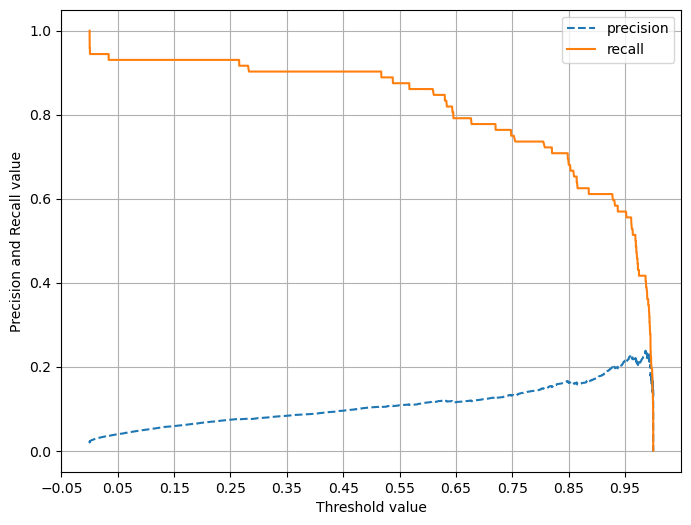

In [39]:
precision_recall_curve_plot(test_y,pred_prob)

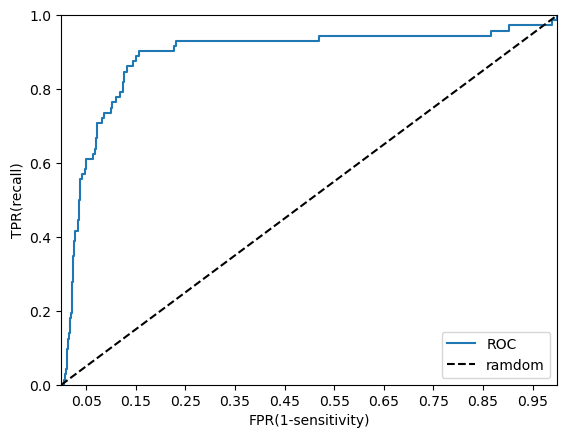

auc 값: 0.8887


In [40]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')